# AdventureWorks - Sales Analysis

This sales analysis uses data from the AdventureWorks2025 database, accessed through SQL Server. Python is employed to retrieve the data and generate visualizations that support a clear and insightful analysis. While the majority of data processing and transformation is performed in SQL, additional transformations are applied in Python when needed to enhance the visualizations.

The analysis, presented in this *Jupyter Notebook*, addresses a series of predefined business questions, alongside one in-depth, supplementary investigation designed to provide deeper insights.

## Code setup

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Password_1234")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\Belson\AppData\Local\Temp\ipykernel_26336\2219564584.py:25: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Analysis

### Products per category

This visualisation analyses how many active products exsist in each category. 

**Database tables:** *Production.Product.Category*, *Production.ProductSubcategory*, *Production.Product*

**Method:** Active products were identified by filtering out discontinued products. Product categories were linked to their corresponding subcategories and products using inner joins. The number of distinct active products was then aggregated per category using a count (distinct) operation. The resulting data was visualised as a bar chart to compare product counts across categories.


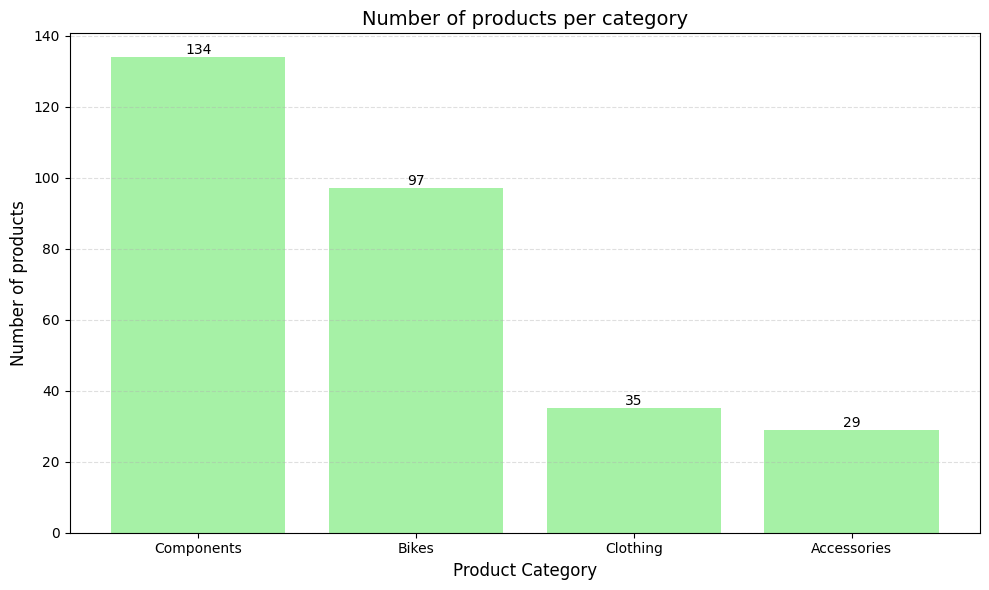

In [3]:
query_vis1 = """ 
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
WHERE p.DiscontinuedDate IS NULL
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='lightgreen', alpha=0.8)

for bar in bars: 
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

ax.set_xlabel('Product Category', fontsize=12)
ax.set_ylabel('Number of products', fontsize=12)
ax.set_title('Number of products per category', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

#### Insights - Products per categories

- Components is the largest product category, comprising 134 products and accounting for nearly half of the total product assortment. This is followed by Bikes, which includes 97 distinct products.

- Clothing and Accessories represent significantly smaller product categories in comparison.

- These findings indicate that the company primarily focuses on Bikes and Components rather than Clothing and Accessories.

### Revenue per category

This visualisation analyses which product categories generate the most revenue.

**Database tables:** *Production.ProductCategory*, *Production.ProductSubcategory*, *Production.Product*, *Sales.SalesOrderDetail*

**Method:** Sales order data was joined with product, subcategory, and category tables to associate each sale with its corresponding product category. Revenue was calculated by aggregating the line totals for each category using a sum operation. The aggregated revenue per category was then visualised using a horizontal bar chart to enable comparison across categories.

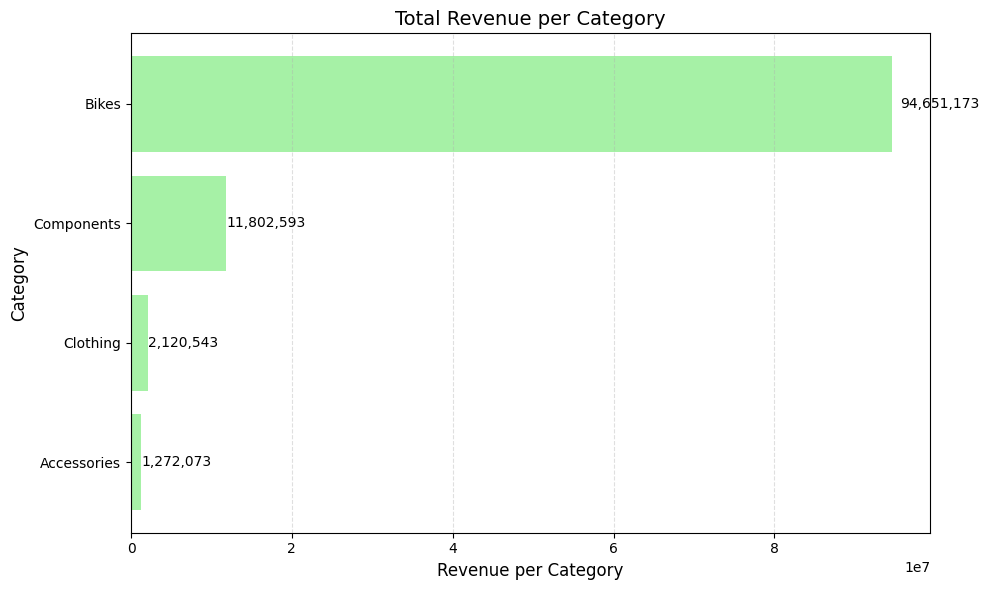

In [4]:
query_vis2 = """ 
SELECT
    pc.Name AS CategoryName,
    CAST(ROUND(SUM(sod.LineTotal), 0) AS BIGINT) AS CategoryRevenue
FROM Sales.SalesOrderDetail sod
LEFT JOIN Production.Product p ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY CategoryRevenue DESC
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['CategoryRevenue'], color='lightgreen', alpha=0.8)

for bar in bars: 
    value = bar.get_width()
    ax.text(
        value * 1.01,
        bar.get_y() + bar.get_height() / 2,
        f'{value:,.0f}',
        va='center',
        ha='left'
    )

ax.set_xlabel('Revenue per Category', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.set_title('Total Revenue per Category', fontsize=14)
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

#### Insights - Total Revenue per Category

- The Bike category generates by far the highest revenue, exceeding 94 million. It is also the second-largest category in terms of number of products.

- Although Components contains the largest number of products, it is not the primary driver of revenue.

- Clothing and Accessories generate the lowest revenue, at approximately 2.1 million and 1.3 million respectively. This aligns with their position as the company’s smallest product segments.

### Monthly Revenue Overtime

This visualisation analyses how monthly revenue has developed over time.

**Database tables:** *Sales.SalesOrderHeader*

**Method:** Order dates were transformed to a monthly level to enable time-based aggregation. Total sales were calculated by summing the order subtotals for each month. The aggregated monthly revenue was then visualised using a line chart to illustrate revenue trends over time.

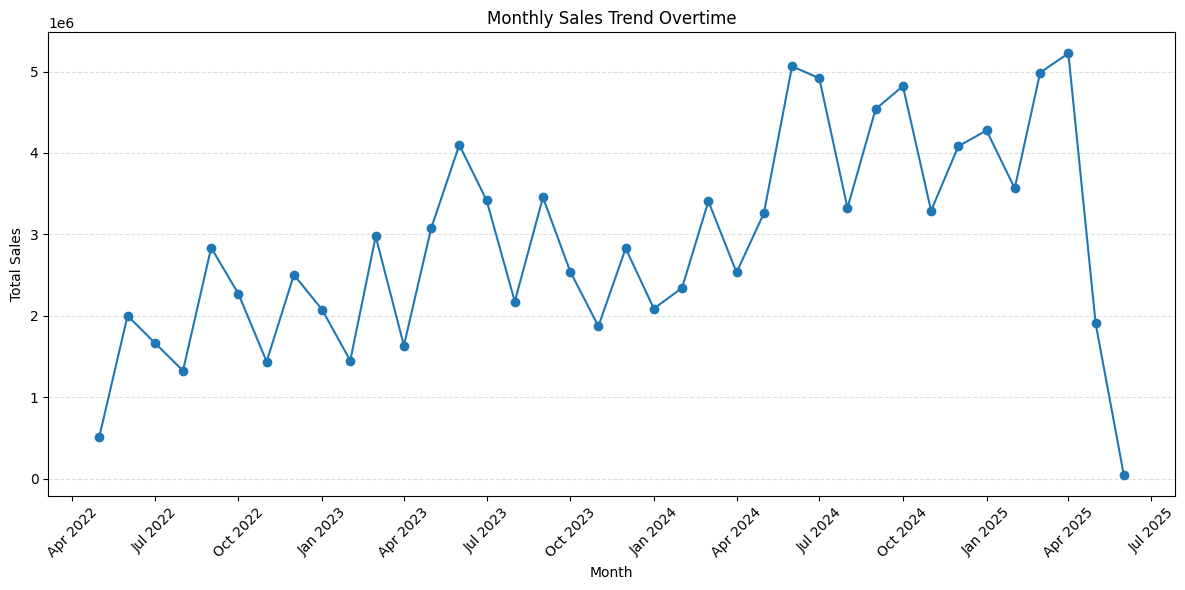

In [5]:
query_vis3 = """ 
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS OrderMonth,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
ORDER BY OrderMonth ASC;
"""

df_vis3 = query_df(query_vis3)

fix, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_vis3["OrderMonth"], df_vis3["TotalSales"], marker='o')

ax.set_xlabel("Month")
ax.set_ylabel("Total Sales")
ax.set_title("Monthly Sales Trend Overtime")
ax.grid(axis='y', linestyle='--', alpha=0.4)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Insights - Monthly Revenue Overtime

- The chart illustrates the development of monthly sales over the period from May 2022 to June 2025.

- Overall, sales show a gradual upward trend across the period, with clear seasonal fluctuations. Revenue tends to increase during early summer, particularly between May and July, most notably in 2023 and 2024.

- After the summer period, sales increase again during August and September 2024, followed by a decline in October and a subsequent rise in November and December.

- The year 2025 shows a strong start, with the highest sales levels in the observed period occurring in February and March. This is followed by a sharp decline in subsequent months.

### Total sales and total orders per year

A grouped bar chart displays total sales and total orders using separate y-axes to account for differences in scale.

**Database tables:** *Sales.SalesOrderHeader*

**Method:** Order data was aggregated at a yearly level by extracting the year from the order date. Total sales were calculated by summing order subtotals, while the total number of orders was calculated by counting sales orders for each year. The results were visualised using a grouped bar chart with dual y-axes to allow comparison between total sales and order volume despite differences in scale.

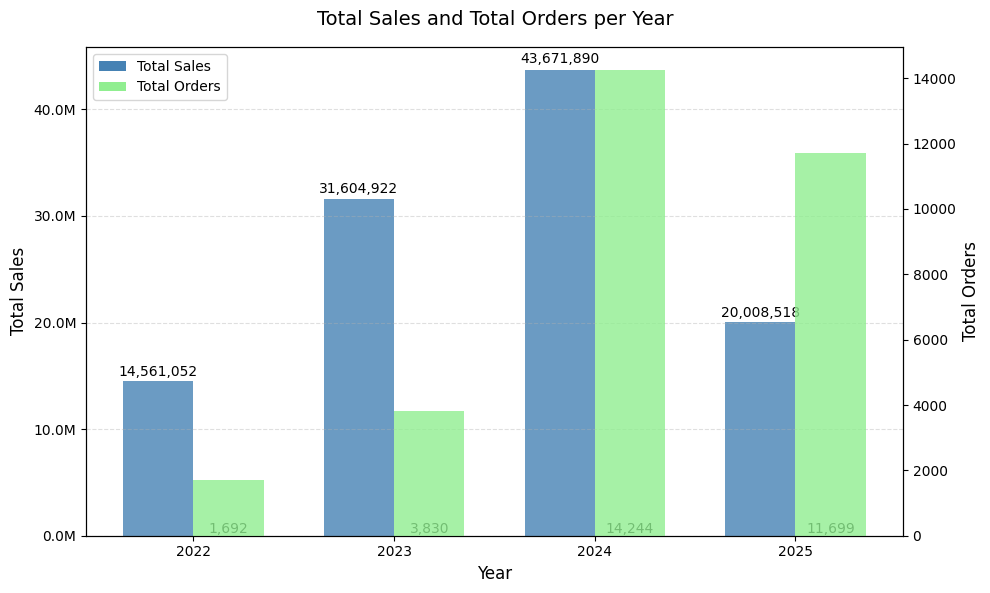

In [6]:
query_vis4 = """ 
SELECT
    YEAR(orderDate) AS OrderYear,
    CAST(ROUND(SUM(SubTotal), 0) AS BIGINT) AS TotalYearSales,
    COUNT(SalesOrderID) AS TotalOrders
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear ASC
"""

df_vis4 = query_df(query_vis4)

x = np.arange(len(df_vis4['OrderYear']))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: Total Sales
bars_sales = ax1.bar(
    x - width/2,
    df_vis4['TotalYearSales'],
    width,
    label='Total Sales',
    color='steelblue',
    alpha=0.8
)

# Right axis: Total Orders
ax2 = ax1.twinx()

bars_orders = ax2.bar(
    x + width/2,
    df_vis4['TotalOrders'],
    width,
    label='Total Orders',
    color='lightgreen',
    alpha=0.8
)

ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['OrderYear'])
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Sales', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax2.set_ylabel('Total Orders', fontsize=12)

ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
)

fig.suptitle('Total Sales and Total Orders per Year', fontsize=14)

legend_handles = [
    Patch(facecolor='steelblue', label='Total Sales'),
    Patch(facecolor='lightgreen', label='Total Orders')
]
ax1.legend(handles=legend_handles, loc='upper left')

for bar in bars_sales:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height * 1.01, 
        f'{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

for bar in bars_orders:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        0, 
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=10,
    )

plt.tight_layout()
plt.show()


#### Insights - Total sales and total orders per year

- The chart illustrates total sales and total orders per year from 2022 to 2025. It should be noted that the figures for 2025 only include data up to May and therefore do not represent a full year.

- Total sales and total orders appear to be positively correlated, as an increase in the number of orders is associated with higher total sales.

- The strongest performance is observed in 2024 - however, if the current trend continues, 2025 has the potential to exceed the total sales recorded in 2024.

### Top 10 products

This visualisation analyses the top ten products generating the highest sales. The figures are aggregated over the time period of May 2022 to June 2025. 

**Database tables:** *Production.Product*, *Sales.SalesOrderDetail*

**Method:** Sales order detail data was joined with product information to associate each sale with its corresponding product. Total sales were aggregated for each product, and the ten products with the highest sales values were selected. The results were visualised using a horizontal bar chart to enable comparison between the top-performing products.

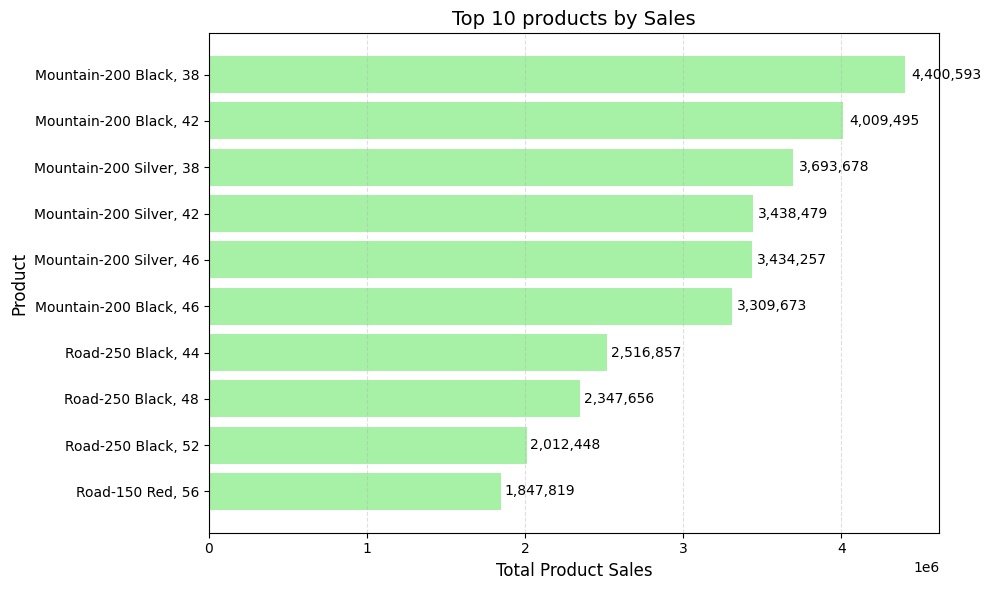

In [7]:
query_vis5 = """ 
SELECT TOP 10
    p.ProductID,
    p.Name AS ProductName,
    CAST(ROUND(SUM(sod.LineTotal), 0) AS BIGINT) AS TotalProductSales
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.ProductID, p.Name
ORDER BY TotalProductSales DESC;
"""

df_vis5 = query_df(query_vis5)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis5['ProductName'], df_vis5['TotalProductSales'], color='lightgreen', alpha=0.8)

for bar in bars: 
    value = bar.get_width()
    ax.text(
        value * 1.01,
        bar.get_y() + bar.get_height() / 2,
        f'{value:,.0f}',
        va='center',
        ha='left'
    )

ax.set_xlabel('Total Product Sales', fontsize=12)
ax.set_ylabel('Product', fontsize=12)
ax.set_title('Top 10 products by Sales', fontsize=14)
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

#### Insights - Top 10 products

- The chart displays the top ten products by total sales value and is dominated by products from the Bike category. These consist primarily of Mountain and Road bikes offered in different sizes and colours.

- The highest-selling product by sales value is the Mountain-200 Black, 38, which has generated approximately 4.4 million in sales.

### Total sales and customer per region

This visualisation analyses how sales differ between regions and how many unique customers there are in each region. The figures are aggregated over the time period of May 2022 to June 2025. 

**Database tables:** *Sales.SalesTerritory*, *Sales.SalesOrderHeader*, *Sales.Customer*

**Method:** Sales territory data was combined with sales order and customer information to associate each order with a specific region. Total sales were aggregated per region, and the number of unique customers was calculated to measure customer reach. The aggregated results were visualised using a grouped bar chart with dual y-axes to allow comparison between total sales and customer counts across regions.

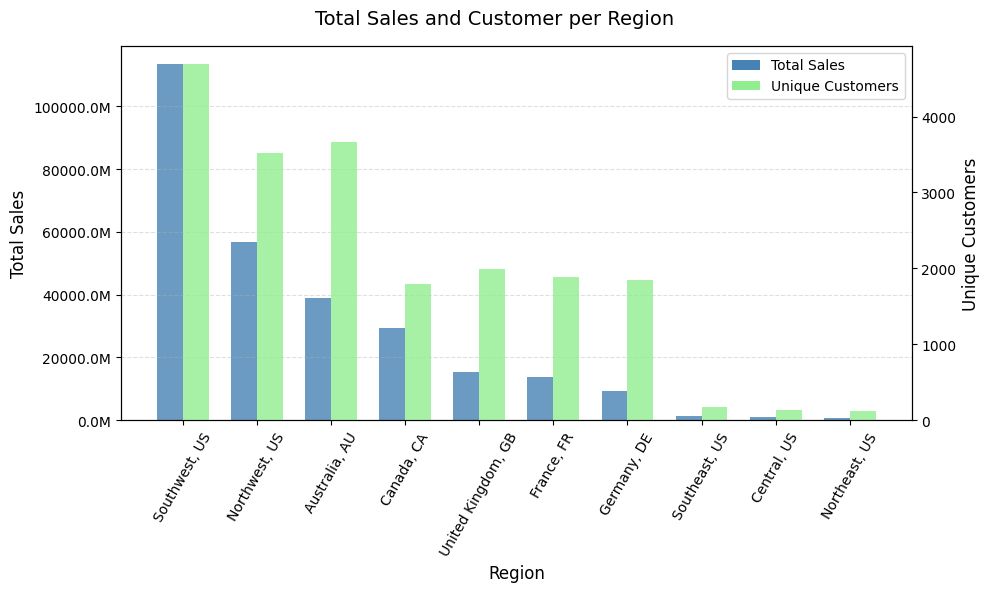

In [8]:
query_vis6 = """ 
SELECT
    CONCAT(st.Name, ', ', st.CountryRegionCode) AS RegionNameCode,
    CAST(ROUND(SUM(soh.SubTotal), 0) AS BIGINT) AS TotalRegionSales,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh 
    ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c 
    ON st.TerritoryID = c.TerritoryID
GROUP BY st.Name, st.CountryRegionCode
ORDER BY TotalRegionSales DESC;
"""

df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6['RegionNameCode']))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: Total Sales
bars_sales = ax1.bar(
    x - width/2,
    df_vis6['TotalRegionSales'],
    width,
    label='Total Sales',
    color='steelblue',
    alpha=0.8
)

# Right axis: Total Customers
ax2 = ax1.twinx()

bars_orders = ax2.bar(
    x + width/2,
    df_vis6['UniqueCustomers'],
    width,
    label='Total Customers',
    color='lightgreen',
    alpha=0.8
)

ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6['RegionNameCode'])
ax1.tick_params(axis='x', labelrotation=60)
ax1.set_xlabel('Region', fontsize=12)
ax1.set_ylabel('Total Sales', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax2.set_ylabel('Unique Customers', fontsize=12)

ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
)

fig.suptitle('Total Sales and Customer per Region', fontsize=14)

legend_handles = [
    Patch(facecolor='steelblue', label='Total Sales'),
    Patch(facecolor='lightgreen', label='Unique Customers')
]
ax1.legend(handles=legend_handles, loc='upper right')

plt.tight_layout()
plt.show()


#### Insights - Total Sales and Customers per Region

- The Southwest region in the US is the strongest in terms of both total sales and number of unique customers, holding the highest figures among all regions.

- The Northeast, Central, and Southeast regions in the US have the lowest sales values and the fewest unique customers.

- While a higher number of unique customers generally corresponds to higher total sales, the relationship does not appear strictly proportional. For example, Australia shows a relatively high number of unique customers but comparatively low total sales.

### AOV per region and customer type

This visualisation analyses the average order value (AOV) across regions and customer types, comparing store and individual customers. The figures are aggregated over the timeperiod of May 2022 to June 2025. 

**Database tables:** *Sales.SalesTerritory*, *Sales.SalesOrderHeader*, *Sales.Customer, *Sales.Store*

**Method:** Sales order data was combined with customer, store, and territory information to associate each order with a region and a customer type (store or individual). Average order value (AOV) was calculated per region and customer type by dividing total sales by the number of orders. The top ten regions based on overall AOV were selected and visualised using a grouped bar chart to compare AOV between store and individual customers across regions.

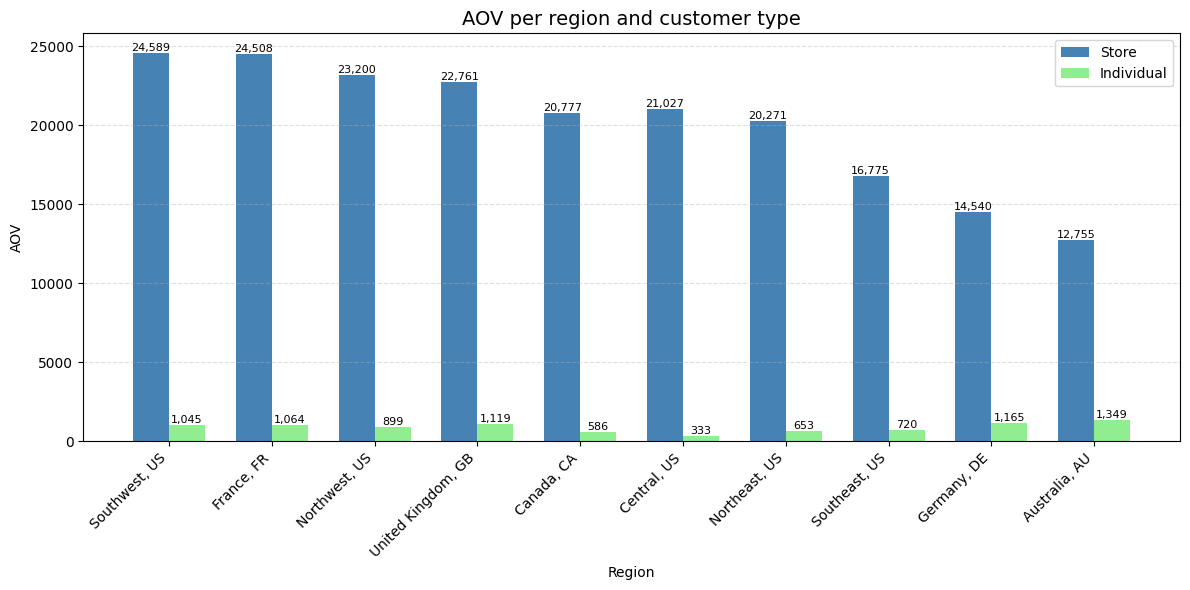

In [9]:
query_vis7 = """ 
SELECT
    CONCAT(st.Name, ', ', st.CountryRegionCode) AS Region,
    CASE
        WHEN s.BusinessEntityID IS NULL THEN 'Individual'
        ELSE 'Store'
    END AS CustomerType,
    SUM(soh.SubTotal) / COUNT(DISTINCT soh.SalesOrderID) AS AverageOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.Customer c 
    ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s
    ON c.StoreID = s.BusinessEntityID
INNER JOIN Sales.SalesTerritory st
    ON c.TerritoryID = st.TerritoryID
GROUP BY 
    st.Name, 
    st.CountryRegionCode,
    CASE
        WHEN s.BusinessEntityID IS NULL THEN 'Individual'
        ELSE 'Store'
    END
ORDER BY AverageOrderValue DESC;
"""

df_vis7 = query_df(query_vis7)

df_pivot = df_vis7.pivot(
    index='Region',
    columns='CustomerType',
    values='AverageOrderValue'
).fillna(0)

df_pivot["TotalAvg"] = df_pivot.mean(axis=1)
df_pivot = df_pivot.sort_values("TotalAvg", ascending=False)

df_pivot = df_pivot.head(10)

x = np.arange(len(df_pivot))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars_store = ax.bar(
    x - width/2,
    df_pivot['Store'],
    width, 
    color='steelblue',
    label='Store'
)

bars_individual = ax.bar(
    x + width/2,
    df_pivot['Individual'],
    width,
    color='lightgreen',
    label='Individual'
)

ax.set_title("AOV per region and customer type", fontsize=14)
ax.set_xlabel("Region")
ax.set_ylabel("AOV")

ax.set_xticks(x)
ax.set_xticklabels(df_pivot.index, rotation=45, ha="right")

ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

for bars in [bars_store, bars_individual]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:,.0f}',
            ha='center',
            va='bottom',
            fontsize=8
            )
        
plt.tight_layout()
plt.show()

#### Insights - AOV per region and customer type

- Store customers have a significantly higher average order value (AOV) than individual customers in all regions.

- The gap between store and individual AOV is especially large in Southwest (US), France, and the United Kingdom, where store orders are more than 20 times larger than individual orders.

- Individual customer AOV is consistently low across all regions, with the highest in Australia and the lowest in Central, US.

- The highest AOV overall is observed for store customers in the Southwest, US, making this the dominant region and customer type combination.

- Regional differences may reflect factors such as local pricing, bulk ordering behavior, and customer segment composition.

### In-depth investigation - 